<a href="https://colab.research.google.com/github/SahilCarterr/Impainting-Diffusers/blob/update_code/Image_Features_Enhancer_More_Accurate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Self Trained YOLOv8 model

In [ ]:
import cv2
! pip install diffusers xformers transformers scipy ftfy accelerate controlnet_aux

In [ ]:
!pip install ultralytics

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
import shutil
import tqdm
import glob
import torch

In [3]:
from ultralytics import YOLO

In [4]:
model = YOLO('/content/drive/MyDrive/new Movie/best_yolo_2.pt')

WARNING ⚠️ 'line_thickness' is deprecated and will be removed in 'ultralytics 8.399999999999999' in the future. Please use 'line_width' instead.
WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.399999999999999' in the future. Please use 'show_labels' instead.

image 1/1 /content/girl_with_shades.jpg: 640x480 1 hat, 1 dress, 38.5ms
Speed: 5.4ms preprocess, 38.5ms inference, 9.2ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict


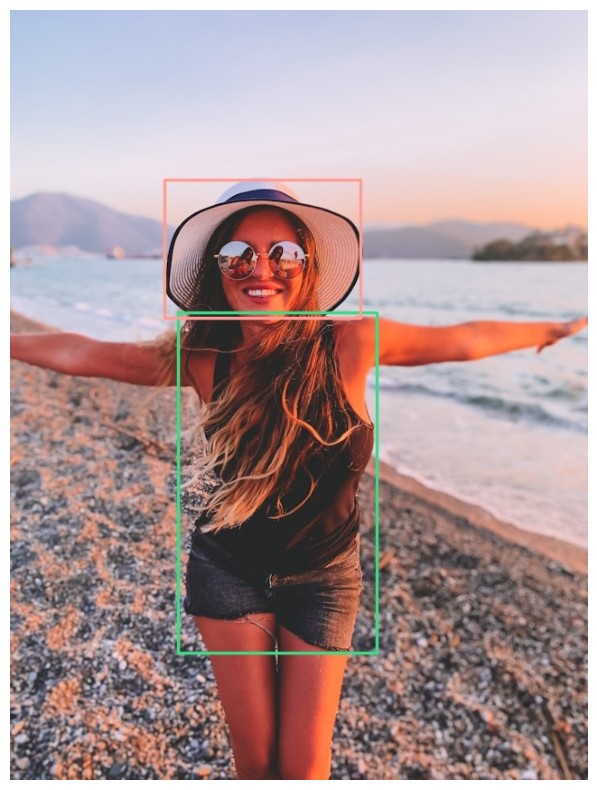

In [14]:
image=model.predict('/content/girl_with_shades.jpg',conf=0.5, save=True, line_thickness=2, hide_labels=False)
im = plt.imread('/content/runs/detect/predict/girl_with_shades.jpg')
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(im)

In [15]:
boxes = image[0].boxes
boxes=boxes.xyxy
print(boxes)

tensor([[171.7714, 188.7172, 388.4796, 341.2744],
        [186.5779, 335.9307, 406.9084, 712.8130]], device='cuda:0')


## Segmentation Model

In [8]:
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-lw9uje2u
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-lw9uje2u
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=3630a0e75f49f958eb500d16cf9fca8a25b0a55e85c194aae2c51893515cec8a
  Stored in directory: /tmp/pip-ephem-wheel-cache-yv9dcvyp/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-05-01 08:38:43--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.11, 3.162.163.51, 3.

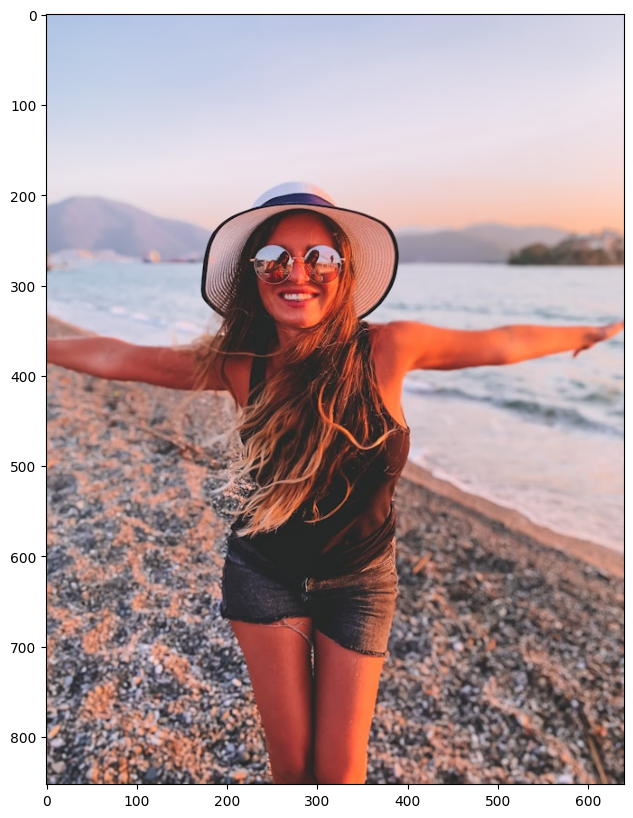

In [24]:
image = cv2.imread('/content/girl_with_shades.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [34]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)

In [35]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255, 255, 255, 1.0])
    #fig = plt.figure()

    # Set the background color to black
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    plt.axis("off")
    ax.imshow(mask_image)
    plt.savefig('mask.png')



def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [29]:
boxes[1]

tensor([186.5779, 335.9307, 406.9084, 712.8130], device='cuda:0')

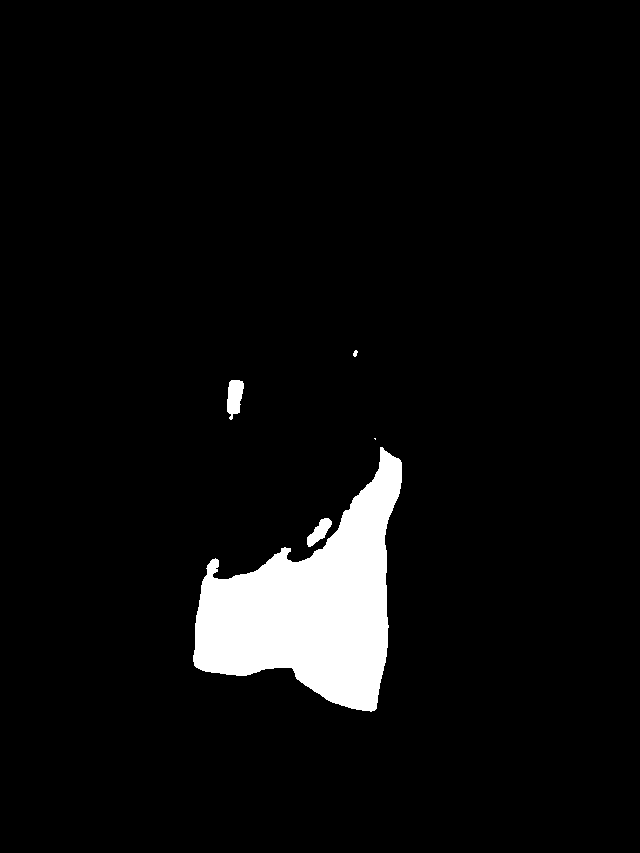

In [47]:
#display mask[0]
from PIL import Image
mass=Image.fromarray(masks[0])
mass

In [54]:
import random

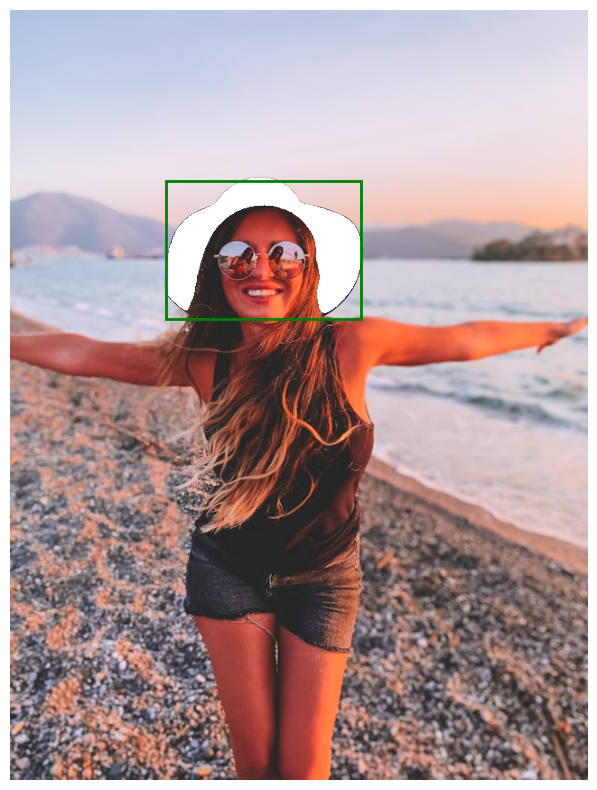

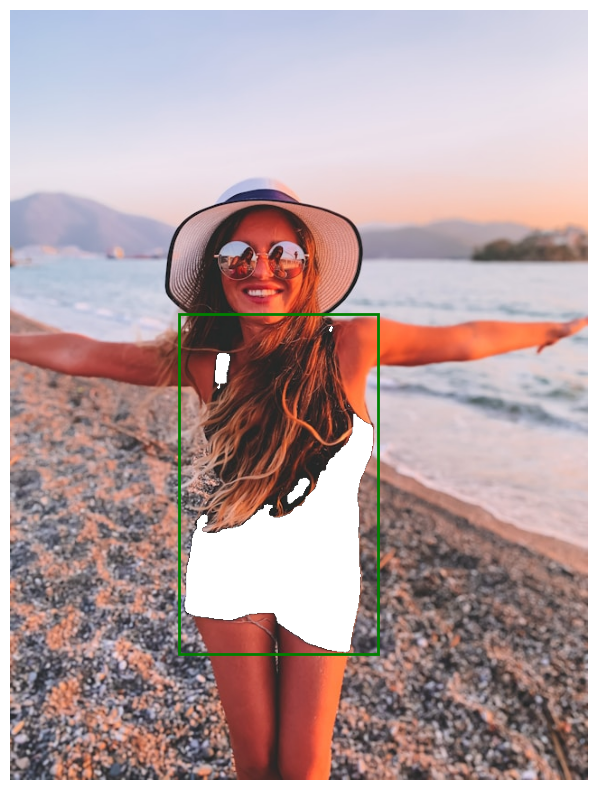

In [57]:
from PIL import Image
os.makedirs("masks", exist_ok=True)
for box in boxes:
  input_box = np.array(box.cpu())
  masks, _, _ = predictor.predict(
      point_coords=None,
      point_labels=None,
      box=input_box[None, :],
      multimask_output=False,
  )
  for mask in masks:
    mass=Image.fromarray(mask)
    mass.save(f"masks/{random.randint(1,1000)}.png")
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_box(input_box, plt.gca())
    plt.axis('off')

In [17]:
new_paths=os.listdir('masks')

##Object style and quality enhancer

In [2]:
! git clone https://github.com/mikonvergence/ControlNetInpaint
import sys
sys.path.append('./ControlNetInpaint/')

fatal: destination path 'ControlNetInpaint' already exists and is not an empty directory.


In [3]:
from diffusers import StableDiffusionInpaintPipeline, ControlNetModel, UniPCMultistepScheduler
from ControlNetInpaint.src import *
from diffusers.utils import load_image

import cv2
from PIL import Image
import numpy as np
import torch
from matplotlib import pyplot as plt

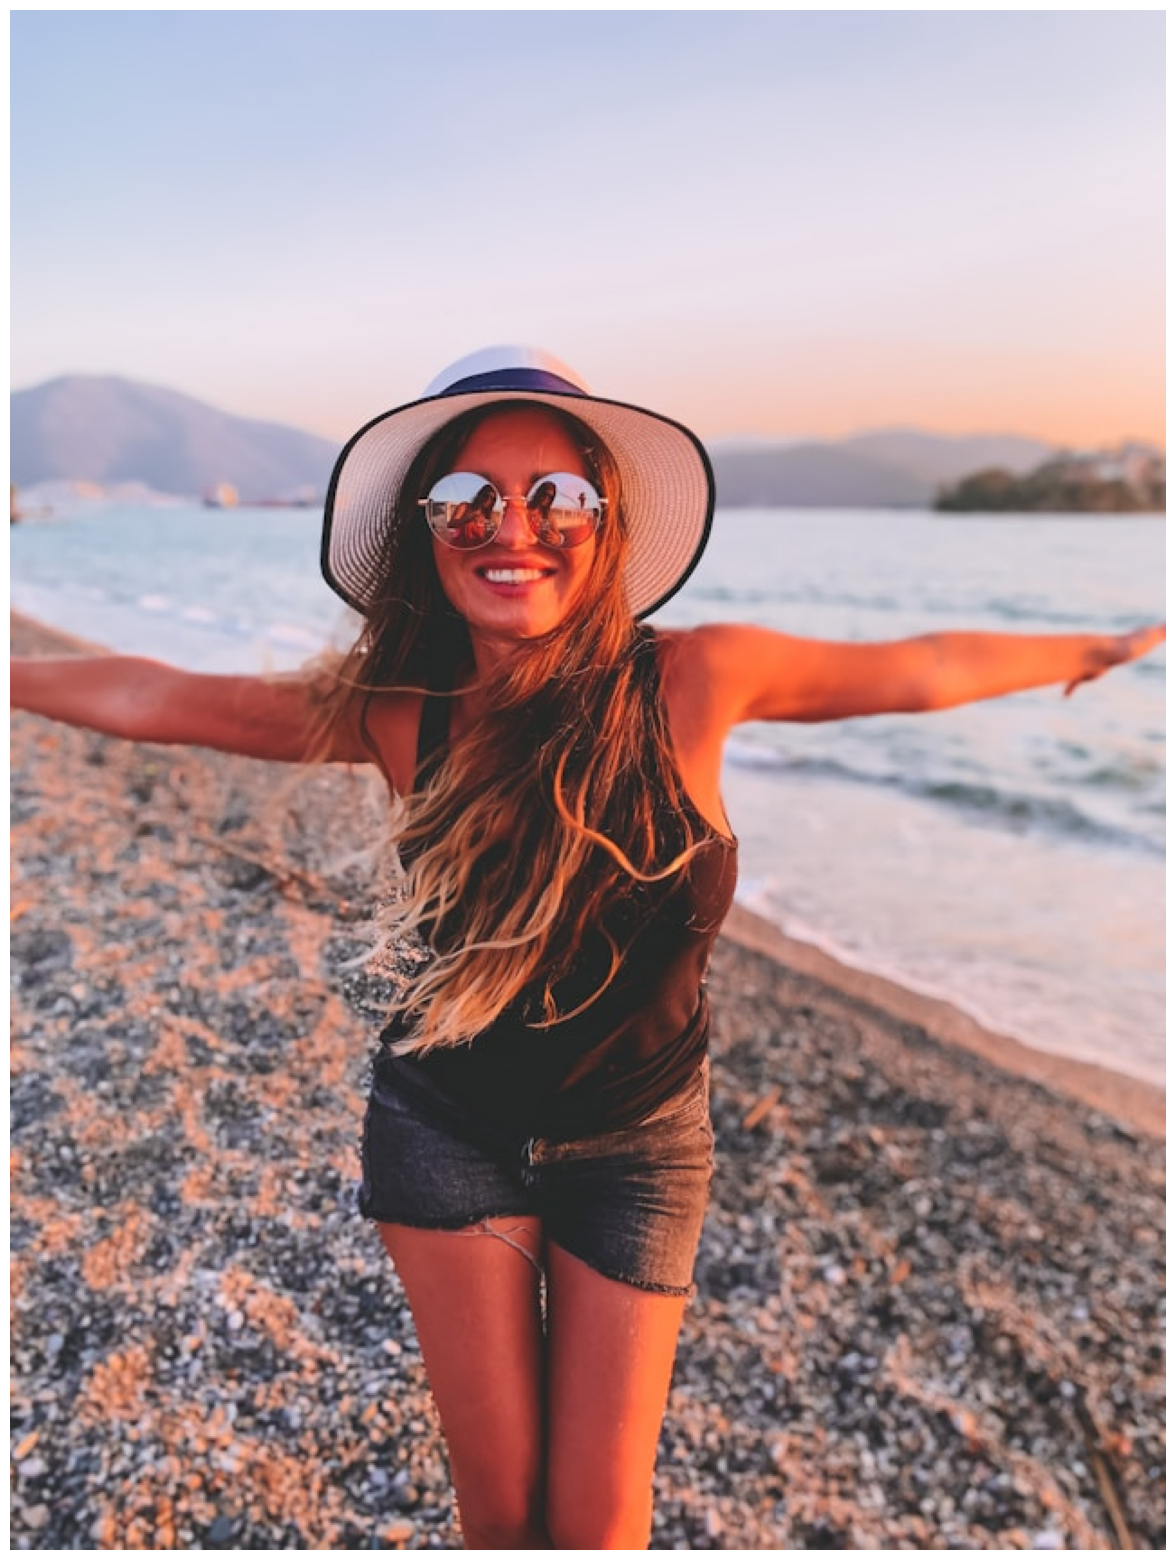

In [4]:
image = cv2.imread('/content/girl_with_shades.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [9]:
image=Image.open("/content/girl_with_shades.jpg")
mask = Image.open("/content/masks/541.png")

In [10]:
image.size, mask.size

((640, 853), (640, 853))

In [7]:
image = np.array(image)
mask_image = np.array(mask)

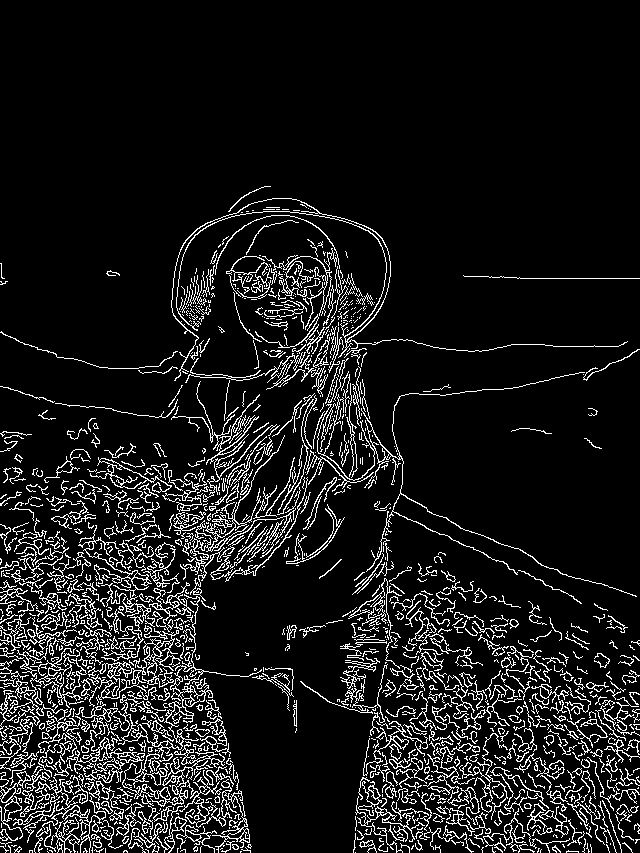

In [8]:
canny_image = cv2.Canny(image, 100, 200)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)

image=Image.fromarray(image)
mask_image=Image.fromarray(mask_image)
canny_image = Image.fromarray(canny_image)

canny_image

In [ ]:
pipe_sd = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
)
# speed up diffusion process with faster scheduler and memory optimization
pipe_sd.scheduler = UniPCMultistepScheduler.from_config(pipe_sd.scheduler.config)
# remove following line if xformers is not installed
pipe_sd.enable_xformers_memory_efficient_attention()

pipe_sd.to('cuda')

In [ ]:
# load control net and stable diffusion v1-5
from diffusers import StableDiffusionControlNetInpaintPipeline
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed
pipe.enable_xformers_memory_efficient_attention()

In [13]:

import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [14]:
def image_enhance(image, mask):
  import cv2
  from PIL import Image
  import numpy as np
  import torch
  from matplotlib import pyplot as plt
  image = np.array(image)
  mask_image = np.array(mask)
  canny_image = cv2.Canny(image, 100, 200)
  canny_image = canny_image[:, :, None]
  canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)

  image=Image.fromarray(image)
  mask_image=Image.fromarray(mask_image)
  canny_image = Image.fromarray(canny_image)
  pipe_sd = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
  )
  # speed up diffusion process with faster scheduler and memory optimization
  pipe_sd.scheduler = UniPCMultistepScheduler.from_config(pipe_sd.scheduler.config)
  # remove following line if xformers is not installed
  pipe_sd.enable_xformers_memory_efficient_attention()

  pipe_sd.to('cuda')
  # load control net and stable diffusion v1-5
  from diffusers import StableDiffusionControlNetInpaintPipeline
  controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
  pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
      "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
  )

  # speed up diffusion process with faster scheduler and memory optimization
  pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
  # remove following line if xformers is not installed
  pipe.enable_xformers_memory_efficient_attention()
  text_prompt="Transform this image into a work of art by changing its style and color palette. Apply a distinct artistic style, such as impressionism, cubism, or surrealism, to give the image a unique and visually striking appearance. Experiment with brush strokes, textures, and effects to achieve the desired artistic effect while maintaining the essence of the original scene. Additionally, adjust the color palette to evoke a specific mood or theme. For example, infuse warm, earthy tones for a rustic and cozy feel, or opt for vibrant, psychedelic colors for a surreal and otherworldly atmosphere. The goal is to reimagine the image in a creative and expressive way, transforming it into a captivating visual masterpiece."
  import os
  os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
  pipe.to('cuda')

  # generate image
  generator = torch.manual_seed(42)
  new_image = pipe(
      text_prompt,
      num_inference_steps=20,
      generator=generator,
      image=image,
      control_image=canny_image,
      controlnet_conditioning_scale = 0.5,
      mask_image=mask_image
  ).images[0]

  return new_image

In [19]:
new_paths

['541.png', '838.png']

In [34]:
#make new image path full
new_paths=os.listdir("/content/masks")
new_paths=[os.path.join("/content/masks", path) for path in new_paths]

In [35]:
new_paths

['/content/masks/541.png', '/content/masks/838.png']

In [36]:
image=Image.open("/content/girl_with_shades.jpg")
update_image=image
for image_path in new_paths:
  mask=Image.open(image_path)
  update_image=image_enhance(update_image, mask)

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:212: FutureWarning: You are loading the variant fp16 from runwayml/stable-diffusion-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (141 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['palette to evoke a specific mood or theme. for example, infuse warm, earthy tones for a rustic and cozy feel, or opt for vibrant, psychedelic colors for a surreal and otherworldly atmosphere. the goal is to reimagine the image in a creative and expressive way, transforming it into a captivating visual masterpiece.']


  0%|          | 0/20 [00:00<?, ?it/s]

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (141 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['palette to evoke a specific mood or theme. for example, infuse warm, earthy tones for a rustic and cozy feel, or opt for vibrant, psychedelic colors for a surreal and otherworldly atmosphere. the goal is to reimagine the image in a creative and expressive way, transforming it into a captivating visual masterpiece.']


  0%|          | 0/20 [00:00<?, ?it/s]

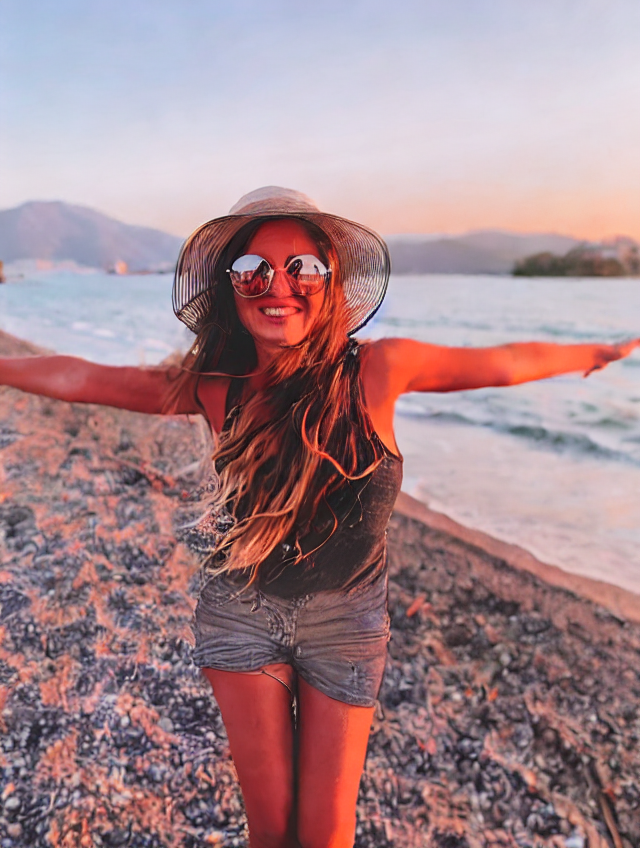

In [37]:
update_image